In [1]:
!pip install biopython
!pip install pyvis
!pip install nglview
!pip install pytraj
!jupyter-nbextension enable nglview --py --sys-prefix

Enabling notebook extension nglview-js-widgets/extension...
      - Validating: OK


In [2]:
### Import **Libraries**

import os
import os.path
import numpy as np
import subprocess
import math
import time
import pdb
import shutil
import networkx as nx
import pytraj as pt
import nglview as nv
from pyvis.network import Network
import matplotlib.pyplot as plt
import sys
# sys.setrecursionlimit(100000)

_ColormakerRegistry()

In [3]:
from collections import Counter
from Bio.PDB import MMCIFParser, PDBParser, Selection, NeighborSearch

def pdb_model(structure_file, water=False):
    """Return a biopython [1] model entity from a structure file.

    Parameters
    ----------
    structure_file: string
        Path to structure file
    water: boolean (default=False)
        True to take into account waker molecules in the structure, False
        otherwise.

    Notes
    -----
    1. http://biopython.org/wiki/Biopython

    """
    accepted_formats = ['cif', 'pdb', 'ent']
    parsers = [MMCIFParser, PDBParser, PDBParser]
    protein_name, file_format = structure_file.rsplit('.', 1)

    try:
        parser = parsers[accepted_formats.index(file_format)]
        parser = parser(QUIET=True)
    except ValueError:
        raise Exception("Accepted structure files are: {}".format(
            accepted_formats))

    structure = parser.get_structure(protein_name, structure_file)
    model = structure[0]

    if not water:
        for chain in model.get_chains():
            for residue in list(chain):
                hetero_flag = residue.id[0].strip()
                # Empty strings evaluate to False.  Therefore hetero_flag
                # returns False if the residue is not a water molecule.
                if hetero_flag:
                    chain.detach_child(residue.id)
            if not list(chain):
                model.detach_child(chain.id)

    return model


def label_residue(residue):
    """ Return a string of the label of the biopython [1] residue object.

    The label of the residue is the following:
        Chain + Position

    Parameters
    ----------
    residue: Bio.PDB.Residue.Residue
        The residue to be labeled.

    Notes
    -----
    1. http://biopython.org/wiki/Biopython

    """
    position = str(residue.id[1])
    chain = residue.parent.id

    return chain + ' ' + position #added space deliminater for split function.

## Residue adjecmatrixtest

In [4]:
#Biopython used to create adjecency dictionary
def residue_adjacency_CO_test(model, cutoff=5, weight=True):
    """Return residue adjacency dictionary defined by cutoff distance.

    Parameters
    ----------
    model: Bio.PDB.Model
        Model created with the atomic coordinates of the protein file.

    cutoff: int or float
        Distance cutoff defining links between atoms.  Two atoms are adjacent
        if their distance is less than the given cutoff.

    See Also
    --------`````````````
    pdb_model

    """
    #Use only the Atoms specified in paper
    atom_list = Selection.unfold_entities(model, 'A')
    atoms = [atom for atom in atom_list if 'O' in atom.name] # 'C' in atom.name or
    #Only looking at oxygen for cliques at the momement, for maximum clique finidng in the residue filteration setup
#     print(atoms)

    neighbor_search = NeighborSearch(atoms)
    atomic_adjacency = {}

    for atom in atoms:
        _res = label_residue(atom.get_parent())
        adjacent_atoms = []
        for adj_atom in neighbor_search.search(atom.coord, cutoff):
            _adj_res = label_residue(adj_atom.parent)
            # Adjacent atoms must be in different residues
            if _adj_res != _res:
                adjacent_atoms.append(adj_atom)
        atomic_adjacency[atom] = adjacent_atoms

    adjacency = {}

    # Create residue adjacency dictionary with string format, see
    # label_residue.
    for atom, neighbors in atomic_adjacency.items():
        residue = label_residue(atom.get_parent())
        adjacency.setdefault(residue, [])

        # Only different residues are connected by an edge (No loops).
        not_in_residue = []
        for neighbor in neighbors:
            neighbor_parent = label_residue(neighbor.get_parent())
            if neighbor_parent is not residue:
                not_in_residue.append(neighbor_parent)

        adjacency[residue].extend(not_in_residue)

    if not weight:

        return adjacency

    # Make new dictionary mapping each residue to its neighbors taking
    # into account the weight.
    weighted_adjacency = {}
    for residue in adjacency:
        counter = Counter(adjacency[residue])
        weighted_adjacency[residue] = {
            neighbor: {'weight': counter[neighbor]}
            for neighbor in counter}

    return weighted_adjacency

In [5]:

def topo_network(model, cutoff=4, weight=True):
    """Return the interaction network of a protein structure.

    The interaction network is defined by a distance cutoff.

    Parameters
    ----------
    model: Bio.PDB.model
        The protein structure.
    cutoff: float
        The distance cutoff defining an interaction between two nodes.
    weight: boolean
        True if atomic interactions are to be considered.
    """

    adjacency_dictionary = residue_adjacency_CO_test(model, cutoff=cutoff,
                                            weight=weight)

    return nx.Graph(adjacency_dictionary)


In [6]:
class Pmolecule(object):
    """Create a Pmolecule object.

    The Pmolecule calls a number of methods for the analysis of protein
    structure. This includes the construction of the interaction network of the
    protein.

    Parameters
    ----------
    structure_file = str
        The path to the structure file of the targeted protein. Three
        structure-file formats are accepted: `pdb', `cif', and `ent'.
    water: boolean, default is False
        If false, water molecules are ignored.

    Attributes
    ----------
    model: Bio.PDB.model
        The structural model of the structure. See www.biopython.org.
    path_to_file: str
        The path to the structural file used to instantiate the class.
    """

    def __init__(self, structure_file, water=False):
        self.model = pdb_model(structure_file, water=water)
        self.path_to_file = structure_file

    def get_network(self, cutoff=5, weight=True):
        """Return the interaction network of a protein structure.

        The interaction network is defined by a distance cutoff.

        Parameters
        ----------
        model: Bio.PDB.model
            The protein structure.
        cutoff: float
            The distance cutoff defining an interaction between two nodes.
        weight: boolean
            True if atomic interactions are to be considered.
        """

        return topo_network(self.model, cutoff=cutoff, weight=weight)

    def get_pdbmodel(self):
        return self.model

In [7]:
########################################################################################################

In [8]:
class FileOperation(object):
    """ generated source for class FileOperation """

    @classmethod
    def getEntriesAsList(cls, fileName):
        """ generated source for method getEntriesAsList """
        #  Return list entries. 
        #  An element of that list is one line of the file fileName.
        fil = open(fileName, "r")
        entries = fil.read().split('\n')
        fil.close()
        return entries

    @classmethod
    def saveResults(cls, entryNames, fileName, option):
        """ generated source for method saveResults """
        #  Write list entryNames in file fileName.
        #  An element in entryNames is one line in fileName.
        if option == "w":
            try:
                with open(fileName, "w") as f:
                    i = 0
                    while i < len(entryNames):
                        f.write(str(entryNames[i]) + "\n")
                        i += 1
            except Exception as e:
                pass

    @classmethod
    def concatenateFiles(cls, outFileName, fileList):
        """ generated source for method concatenateFiles """
        outFileContent = []
        file_ = []
        i = 0
        while i < len(fileList)-1:
          fileName = str((fileList[i]))
          file_ = cls.getEntriesAsList(fileName)
          print("This is the file being concatenated", fileName)
          outFileContent.append(file_)
          i += 1
        # FileOperation.saveResults(outFileContent, outFileName, "w")
        with open(outFileName, 'w') as outfile:
            for fname in outFileContent:
                with open(fname) as infile:
                    for line in infile:
                        outfile.write(line)

In [9]:
class ParsePDB(object):
    """ generated source for class ParsePDB """
    @classmethod
    def getLines(cls, PDBFile, field, subfield, atom):
        """ generated source for method getLines """
        #  Return a list, the element of which is a line in the file with name PDBFile
        #  that contains the specified atom in a specified field.
        returnList = []
        fileList = []
        line = ""
        i = 0
        if atom != "allatom":
            if (0 == len(atom)) or (len(atom) >= 4):
                print("error! in getLines")
        fileList = FileOperation.getEntriesAsList(PDBFile)
        while i < len(fileList):
            line = str(fileList[i])
            if field == "HETATM" and subfield != "HOH" and line.startswith(field) and line[17:20].strip() in atom:
                returnList.append(line)
            if field == "ATOM" and subfield == "Res" and line.startswith(field) and line[13:17].startswith(atom):
                returnList.append(line)
            if field == "HETATM" and subfield == "HOH" and line.startswith(field) and line[12: 14].startswith(atom) and line[17: 20].startswith(subfield):
                returnList.append(line)
            if subfield == "HET":
                if field == "HETATM" and subfield != "HOH" and line.startswith(field) and line[12:14].startswith(atom) and ("HOH" in line[17: 20]) == False:
                    returnList.append(line)
            if field == "ATOM" and subfield == "ResNoWater" and (line.startswith("ATOM") or line.startswith("HETATM")) and atom == "allatom":
                if ("HOH" in line[17:20]) == False:
                    returnList.append(line)
            if field == "ATOM" and subfield == "Res" and (line.startswith("ATOM") or line.startswith("HETATM")) and atom == "allatom":
                returnList.append(line)
            i += 1
        return returnList

    @classmethod
    def getBondedLines(cls, PDBFile, atom, bondedAtom):
        """ generated source for method getBondedLines """
        returnList = []
        carbonList = []
        oxygenList = []
        fileList = []
        line = ""
        i = 0
        if 0 == len(atom) or len(atom) > 1 or 0 == len(bondedAtom) or len(bondedAtom) > 1:
            print("error! in getBondedLines")
        atom = atom.upper()
        bondedAtom = bondedAtom.upper()
        temp = ""
        fileList = FileOperation.getEntriesAsList(PDBFile)
        while i < len(fileList):
            line = str(fileList[i])
            if ("ATOM" in line[0:4]) and (bondedAtom in line[13]):
                carbonList.append(line)
                if temp == "" and (len(oxygenList)==0) == False:
                    k = 0
                    while k < len(oxygenList):
                        returnList.append(str(oxygenList[k]))
                        k += 1
                # print(oxygenList)
                # oxygenList = []
                temp = line[13:14]
            if ("ATOM" in line[0:4]) and (atom in line[13]):
                oxygenList.append(line)
                if temp == "C" and ((len(carbonList)==0) == False):
                    k = 0
                    while k < len(carbonList):
                        returnList.append(str(carbonList[k]))
                        k += 1
                # print(carbonList)
                # carbonList = []
                temp = line[13:14]
            if (("TER" in line[0:4]) or ("HETATM" in line[0:6]) and (0 != len(temp))):
                k = 0
                while k < len(oxygenList):
                    returnList.append(str(oxygenList[k]))
                    k += 1
                # print(oxygenList)
                # oxygenList = []
                temp = ""
            i += 1
        return returnList

In [10]:
def getMetal(filenamearg, metal, PDBID, resultAtoms):
    """ generated source for method getMetal """
    fileList = []
    resultList = []
    allAtom = []
    allAtomNoWater = []
    currDirectory = os.getcwd()
    fileList = FileOperation.getEntriesAsList(filenamearg)
    #  a list of PDBIDs   
    # print(args);
    fileName = currDirectory + "/inputdata/" + PDBID + ".pdb"
    caList = ParsePDB.getLines(fileName, "HETATM", metal, metal)
    # print("This is the caList", caList)
    allAtom = ParsePDB.getLines(fileName, "ATOM", "Res", "allatom")
    pdb_site_list = allAtom + resultAtoms
    FileOperation.saveResults(pdb_site_list, currDirectory + "/predictionResults/" + PDBID + "_site.pdb", "w")
    print("File: " + currDirectory + "/predictionResults/" + PDBID + "_site.pdb" + " just written")
    resultList = []


In [11]:
from Bio.PDB import Entity

def center_of_mass(entity, geometric=False):
    """
    Returns gravitic [default] or geometric center of mass of an Entity.
    Geometric assumes all masses are equal (geometric=True)
    """
    
    # Structure, Model, Chain, Residue
    if isinstance(entity, Entity.Entity):
        atom_list = entity.get_atoms()
    # List of Atoms
    elif hasattr(entity, '__iter__') and [x for x in entity if x.level == 'A']:
        atom_list = entity
    else: # Some other weirdo object
        raise ValueError("Center of Mass can only be calculated from the following objects:\n"
                            "Structure, Model, Chain, Residue, list of Atoms.")
    
    masses = []
    positions = [ [], [], [] ] # [ [X1, X2, ..] , [Y1, Y2, ...] , [Z1, Z2, ...] ]
    
    for atom in atom_list:
        masses.append(atom.mass)
        
        for i, coord in enumerate(atom.coord.tolist()):
            positions[i].append(coord)

    # If there is a single atom with undefined mass complain loudly.
    if 'ukn' in set(masses) and not geometric:
        raise ValueError("Some Atoms don't have an element assigned.\n"
                         "Try adding them manually or calculate the geometrical center of mass instead.")
    
    if geometric:
        return [sum(coord_list)/len(masses) for coord_list in positions]
    else:       
        w_pos = [ [], [], [] ]
        for atom_index, atom_mass in enumerate(masses):
            w_pos[0].append(positions[0][atom_index]*atom_mass)
            w_pos[1].append(positions[1][atom_index]*atom_mass)
            w_pos[2].append(positions[2][atom_index]*atom_mass)

        return [sum(coord_list)/sum(masses) for coord_list in w_pos]

## Experimental

In [12]:
def setup():
    p = subprocess.Popen('mkdir -p ./inputdata; mkdir -p ./outputdata; mkdir -p ./predictionResults; cd inputdata; wget https://files.rcsb.org/download/3cln.pdb; echo "3cln" >> list.txt; cat list.txt; cd .. echo "Created all needed folders";', shell=True, stdout=subprocess.PIPE)
    p.wait()
  # print(str(p.communicate()[0], 'utf-8'))

setup()

In [13]:
metal = 'CA'
fileName = './inputdata/3cln.pdb'
caListtest = ParsePDB.getLines(fileName, "HETATM", metal, metal)
caListtest

['HETATM 1128 CA    CA A 149     -13.638  53.352  31.500  1.00 12.29          CA  ',
 'HETATM 1129 CA    CA A 150     -17.797  50.156  20.859  1.00 15.64          CA  ',
 'HETATM 1130 CA    CA A 151      15.035  17.711  17.954  1.00 28.17          CA  ',
 'HETATM 1131 CA    CA A 152      13.784  23.887   8.345  1.00 29.20          CA  ']

In [14]:
import re
from numpy import array

def vecCaList(caListtest):
    fList = []
    for caitem in caListtest:
        txt=caitem
        re1='.*?'	# Non-greedy match on filler
        re2='([+-]?\\d*\\.\\d+)(?![-+0-9\\.])'	# Float 1
        re3='.*?'	# Non-greedy match on filler
        re4='([+-]?\\d*\\.\\d+)(?![-+0-9\\.])'	# Float 2
        re5='.*?'	# Non-greedy match on filler
        re6='([+-]?\\d*\\.\\d+)(?![-+0-9\\.])'	# Float 3
        rg = re.compile(re1+re2+re3+re4+re5+re6,re.IGNORECASE|re.DOTALL)
        m = rg.search(txt)
        if m:
            float1=m.group(1)
            float2=m.group(2)
            float3=m.group(3)
            print ("("+float1+")"+"("+float2+")"+"("+float3+")"+"\n")
        plhld = [float(float1), float(float2), float(float3)]
        ac = array(plhld)
        fList.append(ac)
    return fList

In [15]:
caList = vecCaList(caListtest)

(-13.638)(53.352)(31.500)

(-17.797)(50.156)(20.859)

(15.035)(17.711)(17.954)

(13.784)(23.887)(8.345)



In [16]:
caList

[array([-13.638,  53.352,  31.5  ]),
 array([-17.797,  50.156,  20.859]),
 array([15.035, 17.711, 17.954]),
 array([13.784, 23.887,  8.345])]

In [17]:
molecule = Pmolecule('./inputdata/3cln.pdb')
view = nv.show_biopython(molecule.get_pdbmodel())
view.clear_representations()
#view as ball and stick (atom and bond)
view.add_ball_and_stick()
# view.add_licorice('ALA, GLU')

In [18]:
view

NGLWidget()

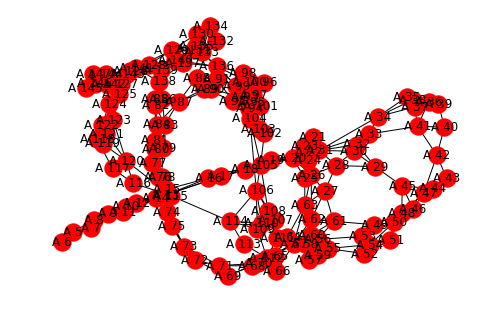

In [51]:
# Create Biograph, uses Biopython for stucture and networkx for drawing the graphs
Graph = molecule.get_network()
nx.draw(Graph, with_labels = True) #, with_labels = True

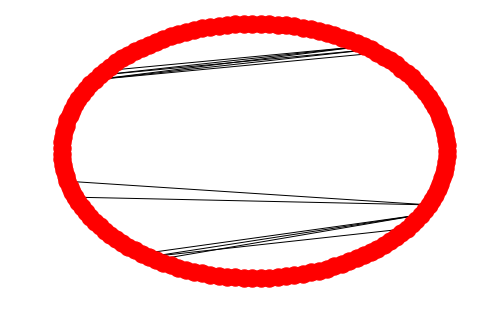

In [20]:
nx.draw_circular(Graph)

In [21]:
vis_net = Network(height="700px", width="100%", notebook=True)

# set the physics layout of the network
vis_net.barnes_hut()
vis_net.from_nx(Graph)
vis_net.show('ex.html')

In [22]:
model = molecule.get_pdbmodel()

In [23]:
adjmatrix = residue_adjacency_CO_test(model, cutoff=4, weight=True)

In [24]:
# adjmatrix

In [25]:
def get_res_cliqs(G, M):
    # Find max cliques
    renamed_cliques=[]
    cliques=[clique for clique in nx.find_cliques(G) if len(clique)>= 4]
    for cliq in cliques:
        c=[]
        for cli in cliq:
            res = M[str(cli.split(' ')[0])][int(cli.split(' ')[1])]
            c.append(res)
        renamed_cliques.append(c)
    print('Number of cliques found: ',len(cliques))
    return(renamed_cliques)

In [26]:
def disResi(G,adj_m, model, cliqueCallback):
    centered_cliq=None
    ress=[res for res in cliqueCallback(G, model)] # add conditions later
    for cliq in ress:
        centered_cliq = ress
    return centered_cliq

#filter each residue with center ca2

In [27]:
reslist = disResi(Graph, adjmatrix, model, get_res_cliqs)

Number of cliques found:  26


In [28]:
reslist

[[<Residue GLU het=  resseq=84 icode= >,
  <Residue GLU het=  resseq=83 icode= >,
  <Residue SER het=  resseq=81 icode= >,
  <Residue ASP het=  resseq=80 icode= >],
 [<Residue ALA het=  resseq=88 icode= >,
  <Residue ARG het=  resseq=90 icode= >,
  <Residue PHE het=  resseq=89 icode= >,
  <Residue GLU het=  resseq=87 icode= >],
 [<Residue ALA het=  resseq=88 icode= >,
  <Residue ARG het=  resseq=90 icode= >,
  <Residue PHE het=  resseq=89 icode= >,
  <Residue VAL het=  resseq=91 icode= >],
 [<Residue ASP het=  resseq=24 icode= >,
  <Residue ASP het=  resseq=20 icode= >,
  <Residue GLY het=  resseq=23 icode= >,
  <Residue ASP het=  resseq=22 icode= >],
 [<Residue ASP het=  resseq=24 icode= >,
  <Residue ASP het=  resseq=20 icode= >,
  <Residue THR het=  resseq=26 icode= >,
  <Residue GLY het=  resseq=25 icode= >],
 [<Residue ASP het=  resseq=24 icode= >,
  <Residue ASP het=  resseq=20 icode= >,
  <Residue THR het=  resseq=26 icode= >,
  <Residue ASP het=  resseq=22 icode= >,
  <Residue 

## Maximal Cliques, Carbon Clusters

In [29]:
#model['A'].get_list()

In [30]:
Struct = model.get_parent()
Struct

<Structure id=./inputdata/3cln>

In [31]:
#get atom from index of residue

In [32]:
def centreCa2(resatoms):
    ans = []
    for i, (atomlist) in enumerate(resatoms):
        if not atomlist:
            continue
        else:
            ans.append(center_of_mass(atomlist))
    return ans

In [33]:
#Given a group of residues, for each atom in the residue return the one with the min(dist) from the any of the HETAM CA
def TestScenerio7(reslist, caList, model):
    # First get oxygen in each residue
    cutoff = 3.5
    resoxygrouped = []
    for resli in reslist:
        grup = []
        for res in resli:
            atom_list = res.get_list()
            resatoms = [atom for atom in atom_list if 'O' in atom.name]
            print(resatoms)
            for acvec in caList:
                alpha_carbon = acvec
                distances = []
                resoxygroup = []
                for i,(atom) in enumerate(resatoms):
                    #subtract the two position vectors
                    print(atom.get_coord())
                    diff_vector = alpha_carbon - atom.get_coord()
                    #to get a positive value we square the difference vector
                    #we then take the square root to go back to the original scale
                    distances.append(np.sqrt(np.sum(diff_vector * diff_vector)))
                    dist = np.sqrt(np.sum(diff_vector * diff_vector))
                    print(i)
                    print('The distances are: ',distances)
                    #we get the nearest atom using min(distances) or dist and see if it falls inside
                    #the cutoff
                    if dist < cutoff:
                        grup.append(atom)
                    print(res)
        resoxygrouped.append(grup)
    return resoxygrouped
#finding Ca binding site from remaining max clique residue


In [34]:
testans = TestScenerio7(reslist, caList, model)

[<Atom O>, <Atom OE1>, <Atom OE2>]
[-0.517 20.391 20.553]
0
The distances are:  [37.12714548982808]
<Residue GLU het=  resseq=84 icode= >
[-6.732 22.092 21.38 ]
1
The distances are:  [37.12714548982808, 33.575212789668775]
<Residue GLU het=  resseq=84 icode= >
[-6.925 20.026 20.673]
2
The distances are:  [37.12714548982808, 33.575212789668775, 35.677873061729]
<Residue GLU het=  resseq=84 icode= >
[-0.517 20.391 20.553]
0
The distances are:  [34.41870445154899]
<Residue GLU het=  resseq=84 icode= >
[-6.732 22.092 21.38 ]
1
The distances are:  [34.41870445154899, 30.171075834496936]
<Residue GLU het=  resseq=84 icode= >
[-6.925 20.026 20.673]
2
The distances are:  [34.41870445154899, 30.171075834496936, 32.03204538921854]
<Residue GLU het=  resseq=84 icode= >
[-0.517 20.391 20.553]
0
The distances are:  [15.993808395696796]
<Residue GLU het=  resseq=84 icode= >
[-6.732 22.092 21.38 ]
1
The distances are:  [15.993808395696796, 22.466261515438006]
<Residue GLU het=  resseq=84 icode= >
[-6

The distances are:  [51.32698122349732, 49.59677288317662]
<Residue ASP het=  resseq=22 icode= >
[-13.702  56.959  33.52 ]
2
The distances are:  [51.32698122349732, 49.59677288317662, 51.073682021285336]
<Residue ASP het=  resseq=22 icode= >
[-15.411  54.604  36.566]
0
The distances are:  [50.91470398734182]
<Residue ASP het=  resseq=22 icode= >
[-14.036  54.809  33.396]
1
The distances are:  [50.91470398734182, 48.55589539290886]
<Residue ASP het=  resseq=22 icode= >
[-13.702  56.959  33.52 ]
2
The distances are:  [50.91470398734182, 48.55589539290886, 49.829890481236355]
<Residue ASP het=  resseq=22 icode= >
[<Atom O>, <Atom OE1>, <Atom OE2>]
[-5.731 51.227 30.32 ]
0
The distances are:  [8.27216238395297]
<Residue GLU het=  resseq=31 icode= >
[-11.595  53.888  32.345]
1
The distances are:  [8.27216238395297, 2.2749003264644085]
<Residue GLU het=  resseq=31 icode= >
[-11.533  52.987  30.447]
2
The distances are:  [8.27216238395297, 2.2749003264644085, 2.381818281924595]
<Residue GLU h

[-14.863  42.359  34.738]
0
The distances are:  [43.109811241338576]
<Residue LYS het=  resseq=13 icode= >
[<Atom O>]
[-14.379  40.071  32.268]
0
The distances are:  [13.323809164724354]
<Residue PHE het=  resseq=12 icode= >
[-14.379  40.071  32.268]
0
The distances are:  [15.606257870829834]
<Residue PHE het=  resseq=12 icode= >
[-14.379  40.071  32.268]
0
The distances are:  [39.62377545474932]
<Residue PHE het=  resseq=12 icode= >
[-14.379  40.071  32.268]
0
The distances are:  [40.34087733898808]
<Residue PHE het=  resseq=12 icode= >
[<Atom O>, <Atom OE1>, <Atom OE2>]
[-11.646  41.915  35.844]
0
The distances are:  [12.39529603522672]
<Residue GLU het=  resseq=14 icode= >
[-14.199  36.953  39.319]
1
The distances are:  [12.39529603522672, 18.176322957263682]
<Residue GLU het=  resseq=14 icode= >
[-12.038  37.205  39.307]
2
The distances are:  [12.39529603522672, 18.176322957263682, 18.006520656059262]
<Residue GLU het=  resseq=14 icode= >
[-11.646  41.915  35.844]
0
The distances a

The distances are:  [8.365991748352537, 2.3166992388980705, 2.763911510646511]
<Residue GLU het=  resseq=104 icode= >
[10.69  10.994 15.506]
0
The distances are:  [15.069246535729734]
<Residue GLU het=  resseq=104 icode= >
[14.063 15.928 16.839]
1
The distances are:  [15.069246535729734, 11.64352019818123]
<Residue GLU het=  resseq=104 icode= >
[14.887 15.027 18.597]
2
The distances are:  [15.069246535729734, 11.64352019818123, 13.59484123177847]
<Residue GLU het=  resseq=104 icode= >
[<Atom O>, <Atom OD1>, <Atom OD2>]
[12.063 17.019 21.486]
0
The distances are:  [45.616976402196165]
<Residue ASP het=  resseq=93 icode= >
[12.724 20.092 20.169]
1
The distances are:  [45.616976402196165, 43.926919452046384]
<Residue ASP het=  resseq=93 icode= >
[13.313 18.284 19.079]
2
The distances are:  [45.616976402196165, 43.926919452046384, 45.93911417974446]
<Residue ASP het=  resseq=93 icode= >
[12.063 17.019 21.486]
0
The distances are:  [44.61024031921762]
<Residue ASP het=  resseq=93 icode= >
[

2
The distances are:  [36.916591544402586, 41.023385503249166, 41.03914721822977]
<Residue GLU het=  resseq=140 icode= >
[ 5.337 23.789  9.351]
0
The distances are:  [14.317992058267011]
<Residue GLU het=  resseq=140 icode= >
[11.416 23.758  9.341]
1
The distances are:  [14.317992058267011, 11.128662820433508]
<Residue GLU het=  resseq=140 icode= >
[11.9   25.077  7.693]
2
The distances are:  [14.317992058267011, 11.128662820433508, 13.014388296587745]
<Residue GLU het=  resseq=140 icode= >
[ 5.337 23.789  9.351]
0
The distances are:  [8.507258697929526]
<Residue GLU het=  resseq=140 icode= >
[11.416 23.758  9.341]
1
The distances are:  [8.507258697929526, 2.5721739103216943]
<Residue GLU het=  resseq=140 icode= >
[11.9   25.077  7.693]
2
The distances are:  [8.507258697929526, 2.5721739103216943, 2.3217796724390887]
<Residue GLU het=  resseq=140 icode= >
[<Atom O>, <Atom OD1>, <Atom OD2>]
[16.789 27.007  5.137]
0
The distances are:  [48.11308650725743]
<Residue ASP het=  resseq=131 ic

[ 4.667  5.681 13.265]
0
The distances are:  [54.22280377838991]
<Residue MET het=  resseq=109 icode= >
[ 4.667  5.681 13.265]
0
The distances are:  [50.4016440491845]
<Residue MET het=  resseq=109 icode= >
[ 4.667  5.681 13.265]
0
The distances are:  [16.559077268329773]
<Residue MET het=  resseq=109 icode= >
[ 4.667  5.681 13.265]
0
The distances are:  [20.947184136396352]
<Residue MET het=  resseq=109 icode= >
[<Atom O>]
[ 5.501  7.737 15.936]
0
The distances are:  [51.858149256476324]
<Residue VAL het=  resseq=108 icode= >
[ 5.501  7.737 15.936]
0
The distances are:  [48.645701689570416]
<Residue VAL het=  resseq=108 icode= >
[ 5.501  7.737 15.936]
0
The distances are:  [13.944538649011989]
<Residue VAL het=  resseq=108 icode= >
[ 5.501  7.737 15.936]
0
The distances are:  [19.673684698124916]
<Residue VAL het=  resseq=108 icode= >
[<Atom O>]
[ 9.501  6.832 13.356]
0
The distances are:  [55.033885000390356]
<Residue ARG het=  resseq=106 icode= >
[ 9.501  6.832 13.356]
0
The distanc

[ 8.291  2.656 15.437]
1
The distances are:  [56.228617044720735, 57.52378154717642]
<Residue THR het=  resseq=110 icode= >
[ 5.111  2.853 15.376]
0
The distances are:  [52.843292548814716]
<Residue THR het=  resseq=110 icode= >
[ 8.291  2.656 15.437]
1
The distances are:  [52.843292548814716, 54.463123797047565]
<Residue THR het=  resseq=110 icode= >
[ 5.111  2.853 15.376]
0
The distances are:  [18.052479688790044]
<Residue THR het=  resseq=110 icode= >
[ 8.291  2.656 15.437]
1
The distances are:  [18.052479688790044, 16.687415819165107]
<Residue THR het=  resseq=110 icode= >
[ 5.111  2.853 15.376]
0
The distances are:  [23.81354769362727]
<Residue THR het=  resseq=110 icode= >
[ 8.291  2.656 15.437]
1
The distances are:  [23.81354769362727, 23.04831616767308]
<Residue THR het=  resseq=110 icode= >
[<Atom O>]
[ 8.684  6.376 16.27 ]
0
The distances are:  [54.193811026235295]
<Residue HIS het=  resseq=107 icode= >
[ 8.684  6.376 16.27 ]
0
The distances are:  [51.37110749198487]
<Residue

In [35]:
print('The length is: ', len(testans))
testans

The length is:  26


[[],
 [],
 [],
 [<Atom OD2>, <Atom OD2>, <Atom OD1>],
 [<Atom OD2>, <Atom OD2>, <Atom O>],
 [<Atom OD2>, <Atom OD2>, <Atom O>, <Atom OD1>, <Atom OE1>, <Atom OE2>],
 [<Atom OD2>, <Atom OD2>, <Atom OD1>],
 [<Atom OD2>, <Atom OD2>, <Atom OD1>, <Atom OE1>, <Atom OE2>, <Atom O>],
 [],
 [<Atom OE1>, <Atom OE2>],
 [],
 [<Atom O>, <Atom OD1>, <Atom OD2>],
 [<Atom OE1>, <Atom OE2>, <Atom OD2>, <Atom OD2>, <Atom OD1>, <Atom O>],
 [<Atom OE1>, <Atom OE2>, <Atom OD2>, <Atom OD2>],
 [],
 [],
 [<Atom O>, <Atom OE1>, <Atom OE2>, <Atom OD2>, <Atom OD1>, <Atom OD2>],
 [],
 [],
 [],
 [<Atom OD2>, <Atom OD2>, <Atom OD1>],
 [],
 [],
 [<Atom O>, <Atom OD2>, <Atom OD1>],
 [<Atom O>, <Atom O>],
 []]

In [36]:
# Center of mass coordinates
finalanstest = centreCa2(testans)
finalanstest

[[-14.801666577657063, 53.37366612752278, 32.56766637166341],
 [-14.855999946594238, 52.35499954223633, 31.343666712443035],
 [-13.622000058492027, 53.12483278910318, 31.703166961669925],
 [-17.954333623250324, 51.03733317057292, 19.67233276367188],
 [-17.60100015004476, 49.979166666666664, 20.53316656748454],
 [11.657999992370605, 24.417499542236328, 8.5169997215271],
 [-16.831000010172524, 51.157666524251304, 20.677333196004234],
 [14.801833152771, 17.57250006993612, 18.161333719889324],
 [14.647499799728395, 16.7092502117157, 18.568000316619873],
 [13.515999952952068, 23.767499605814617, 8.075999816258747],
 [15.24033292134603, 18.572333017985027, 19.033000310262043],
 [14.511333147684734, 18.960666656494144, 17.9250005086263],
 [-15.11899995803833, 51.23749923706055, 25.86300086975098]]

In [37]:
def writeresultAtoms(cacmcoord):
    ans = []
    for coord in cacmcoord:
        print(coord)
        cacoord = "HETATM      CA    CA" + "           " + str(coord[0])[:-12] +"  " + str(coord[1])[:-12] + "  " + str(coord[2])[:-12]
        print(cacoord)
        ans.append(cacoord)
    return ans

In [38]:
filenamearg = './inputdata/3cln.pdb'
metal ='CA'
PDBID = '3cln'
resultAtoms = writeresultAtoms(finalanstest)
getMetal(filenamearg, metal, PDBID, resultAtoms)

[-14.801666577657063, 53.37366612752278, 32.56766637166341]
HETATM      CA    CA           -14.801  53.37  32.56
[-14.855999946594238, 52.35499954223633, 31.343666712443035]
HETATM      CA    CA           -14.855  52.35  31.343
[-13.622000058492027, 53.12483278910318, 31.703166961669925]
HETATM      CA    CA           -13.622  53.12  31.703
[-17.954333623250324, 51.03733317057292, 19.67233276367188]
HETATM      CA    CA           -17.954  51.03  19.67
[-17.60100015004476, 49.979166666666664, 20.53316656748454]
HETATM      CA    CA           -17.60  49.979  20.53
[11.657999992370605, 24.417499542236328, 8.5169997215271]
HETATM      CA    CA           11.657  24.417  8.5
[-16.831000010172524, 51.157666524251304, 20.677333196004234]
HETATM      CA    CA           -16.831  51.157  20.677
[14.801833152771, 17.57250006993612, 18.161333719889324]
HETATM      CA    CA           14.  17.57  18.161
[14.647499799728395, 16.7092502117157, 18.568000316619873]
HETATM      CA    CA           14.647  

In [39]:
# 133 OD1    20 ASP  -13.468  52.741  31.769 1128  0.69     3.24    
# 150 OD1    22 ASP  -13.468  52.741  31.769 1128  0.69     3.24    
# 171 O      26 THR  -13.468  52.741  31.769 1128  0.69     3.24    
# 213 OE1    31 GLU  -13.468  52.741  31.769 1128  0.69     3.24 
s = [model['A'][20]["OD1"],model['A'][22]["OD1"],model['A'][26]["O"],model['A'][31]["OE1"]]
print(s)

print(center_of_mass.__doc__)


print(center_of_mass(s, geometric=True))

[<Atom OD1>, <Atom OD1>, <Atom O>, <Atom OE1>]

    Returns gravitic [default] or geometric center of mass of an Entity.
    Geometric assumes all masses are equal (geometric=True)
    
[-13.914250135421753, 52.65074920654297, 32.1657509803772]


In [40]:
def filterCallback(atoms, caList, model):
    for atom in atoms:
        centeredcheckresi = []
        res = atom.get_parent()
        diff = res['CA'].get_vector() - atom.get_vector()
        dist = np.sqrt(np.sum(diff * diff))
        if dist <= 3.5:
            return res
        else:
            continue

In [41]:
def filterMaxCliqRes(reslist, caList, model):
    # First get oxygen in each residue
    remnoxy = []
    for resli in reslist:
        for res in resli:
            atom_list = res.get_list()
            atoms = [atom for atom in atom_list if 'O' in atom.name]
            filtered = filterCallback(atoms, caList, model)
            remnoxy.append(list(filtered))
    return(remnoxy)

In [42]:
lsoa = filterMaxCliqRes(reslist, caList, model)

In [43]:
lsoa

[[<Atom N>,
  <Atom CA>,
  <Atom C>,
  <Atom O>,
  <Atom CB>,
  <Atom CG>,
  <Atom CD>,
  <Atom OE1>,
  <Atom OE2>],
 [<Atom N>,
  <Atom CA>,
  <Atom C>,
  <Atom O>,
  <Atom CB>,
  <Atom CG>,
  <Atom CD>,
  <Atom OE1>,
  <Atom OE2>],
 [<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>, <Atom OG>],
 [<Atom N>,
  <Atom CA>,
  <Atom C>,
  <Atom O>,
  <Atom CB>,
  <Atom CG>,
  <Atom OD1>,
  <Atom OD2>],
 [<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>],
 [<Atom N>,
  <Atom CA>,
  <Atom C>,
  <Atom O>,
  <Atom CB>,
  <Atom CG>,
  <Atom CD>,
  <Atom NE>,
  <Atom CZ>,
  <Atom NH1>,
  <Atom NH2>],
 [<Atom N>,
  <Atom CA>,
  <Atom C>,
  <Atom O>,
  <Atom CB>,
  <Atom CG>,
  <Atom CD1>,
  <Atom CD2>,
  <Atom CE1>,
  <Atom CE2>,
  <Atom CZ>],
 [<Atom N>,
  <Atom CA>,
  <Atom C>,
  <Atom O>,
  <Atom CB>,
  <Atom CG>,
  <Atom CD>,
  <Atom OE1>,
  <Atom OE2>],
 [<Atom N>, <Atom CA>, <Atom C>, <Atom O>, <Atom CB>],
 [<Atom N>,
  <Atom CA>,
  <Atom C>,
  <Atom O>,
  <Atom CB>,
  <Atom CG>,
  <Ato

In [44]:
center_of_mass(lsoa[0], geometric=True)

[-3.8986666666136847, 21.270555284288193, 21.036222245958115]

In [45]:
#Links
#http://www.rcsb.org/3d-view/1B8C/1

In [46]:
# cliques=[clique for clique in nx.find_cliques(Graph) if len(clique)<=4]
# print('Number of cliques found: ',len(cliques))
# print(cliques)

In [47]:
#Print out the coordinates of all CA atoms in a structure with B factor greater than 50
for chain in model.get_list():
  for residue in chain.get_list():
    if residue.has_id("CA"):
      ca = residue["CA"]
      if ca.get_bfactor() > 55.0:
        print(ca.get_coord())
# For for each carbon alpha in a residue find neigbor oxygen 

[-6.314 26.41  23.052]
[-0.327 21.086 10.763]
[-2.833 23.864 10.177]
[-2.095 24.829  6.582]


In [48]:
def FilterTest17(model):
  #finding Ca binding site from remaining max clique residue
  cutoff = 3.5
  binding_residues = []
  for res in model.get_residues():
      alpha_carbon = res['CA']
      distances = []
      for atom in res:
          #subtract the two position vectors
          diff_vector = alpha_carbon.get_vector() - atom.get_vector()
          #to get a positive value we square the difference vector
          #we then take the square root to go back to the original scale
          distances.append(np.sqrt(np.sum(diff_vector * diff_vector)))
      #we get the nearest atom using min(distances) and see if it falls inside
      #the cutoff
      if min(distances) < cutoff:
          binding_residues.append(res)
  print(binding_residues)

FilterTest17(model)

[<Residue THR het=  resseq=5 icode= >, <Residue GLU het=  resseq=6 icode= >, <Residue GLU het=  resseq=7 icode= >, <Residue GLN het=  resseq=8 icode= >, <Residue ILE het=  resseq=9 icode= >, <Residue ALA het=  resseq=10 icode= >, <Residue GLU het=  resseq=11 icode= >, <Residue PHE het=  resseq=12 icode= >, <Residue LYS het=  resseq=13 icode= >, <Residue GLU het=  resseq=14 icode= >, <Residue ALA het=  resseq=15 icode= >, <Residue PHE het=  resseq=16 icode= >, <Residue SER het=  resseq=17 icode= >, <Residue LEU het=  resseq=18 icode= >, <Residue PHE het=  resseq=19 icode= >, <Residue ASP het=  resseq=20 icode= >, <Residue LYS het=  resseq=21 icode= >, <Residue ASP het=  resseq=22 icode= >, <Residue GLY het=  resseq=23 icode= >, <Residue ASP het=  resseq=24 icode= >, <Residue GLY het=  resseq=25 icode= >, <Residue THR het=  resseq=26 icode= >, <Residue ILE het=  resseq=27 icode= >, <Residue THR het=  resseq=28 icode= >, <Residue THR het=  resseq=29 icode= >, <Residue LYS het=  resseq=30 

In [49]:
# def envclean():
#     p = subprocess.Popen('rm -r ./inputdata; rm -r ./outputdata; rm -r ./predictionResults; "Del all needed folders";', shell=True, stdout=subprocess.PIPE)
#     p.wait()
#   # print(str(p.communicate()[0], 'utf-8'))

# envclean()

In [50]:
#! ./clean.sh